In [1]:
import os

In [2]:
import pandas as pd

In [3]:
import geopandas as gpd

In [74]:
import seaborn as sns
sns.set()

In [3]:
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/600.1.17\
 (KHTML, like Gecko) Version/8.0 Safari/600.1.17'

In [4]:
dataset_url = 'https://cdn.tse.jus.br/estatistica/sead/odsele/votacao_candidato_munzona/votacao_candidato_munzona_2018.zip'

In [7]:
file_to_extract = 'votacao_candidato_munzona_2018_BRASIL.csv'

In [4]:
os.chdir('C:\\Users\\rgarcia\\Documents\\data')

In [5]:
os.listdir()[0:10]

['bands.csv',
 'Biomas',
 'brasil_coverage_2021.tif',
 'brasil_coverage_2021.tif.aux.xml',
 'brazil-states.geojson',
 'brazil-states_lo_res.json',
 'brazil_forests.pgw',
 'candidato_redes_total.csv',
 'cargo.csv',
 'consulta_cand_2018_BRASIL.csv']

In [ ]:
# os.system(f'wget --header="User-Agent: {user_agent}" {dataset_url}')

In [ ]:
# os.system(f'unzip -p {dataset_url.split('/')[-1]} {file_to_extract} > {file_to_extract}')

In [6]:
# os.remove(dataset_url.split('/')[-1])

In [ ]:
# Cell below takes about a minute to run

In [8]:
df = pd.read_csv(file_to_extract, sep=';', encoding='ISO-8859-1', decimal=',', thousands='.')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8671350 entries, 0 to 8671349
Data columns (total 38 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   DT_GERACAO                object
 1   HH_GERACAO                object
 2   ANO_ELEICAO               int64 
 3   CD_TIPO_ELEICAO           int64 
 4   NM_TIPO_ELEICAO           object
 5   NR_TURNO                  int64 
 6   CD_ELEICAO                int64 
 7   DS_ELEICAO                object
 8   DT_ELEICAO                object
 9   TP_ABRANGENCIA            object
 10  SG_UF                     object
 11  SG_UE                     object
 12  NM_UE                     object
 13  CD_MUNICIPIO              int64 
 14  NM_MUNICIPIO              object
 15  NR_ZONA                   int64 
 16  CD_CARGO                  int64 
 17  DS_CARGO                  object
 18  SQ_CANDIDATO              int64 
 19  NR_CANDIDATO              int64 
 20  NM_CANDIDATO              object
 21  NM_URNA_

In [10]:
df = df.query('NR_TURNO == 2')

In [11]:
df = df.query('DS_CARGO == "Presidente"')

In [12]:
df = df[['SG_UF', 'CD_MUNICIPIO',
       'NM_MUNICIPIO', 
       'NR_CANDIDATO', 'NM_URNA_CANDIDATO',
       'DS_SITUACAO_CANDIDATURA', 
       'DS_DETALHE_SITUACAO_CAND', 'TP_AGREMIACAO','SG_PARTIDO',
       'CD_SIT_TOT_TURNO', 'DS_SIT_TOT_TURNO', 'ST_VOTO_EM_TRANSITO',
       'QT_VOTOS_NOMINAIS']]

In [13]:
agrupa = df.groupby(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'SG_UF', 'NM_URNA_CANDIDATO']).QT_VOTOS_NOMINAIS.sum()

In [14]:
agrupa = agrupa.reset_index()

In [21]:
agrupa.head(10)

,CD_MUNICIPIO,NM_MUNICIPIO,SG_UF,NM_URNA_CANDIDATO,QT_VOTOS_NOMINAIS
0,19,GUAJARÁ-MIRIM,RO,FERNANDO HADDAD,5844
1,19,GUAJARÁ-MIRIM,RO,JAIR BOLSONARO,12838
2,35,PORTO VELHO,RO,FERNANDO HADDAD,74847
3,35,PORTO VELHO,RO,JAIR BOLSONARO,166145
4,51,JI-PARANÁ,RO,FERNANDO HADDAD,14174
5,51,JI-PARANÁ,RO,JAIR BOLSONARO,48520
6,78,ARIQUEMES,RO,FERNANDO HADDAD,8862
7,78,ARIQUEMES,RO,JAIR BOLSONARO,37325
8,94,CACOAL,RO,FERNANDO HADDAD,10091
9,94,CACOAL,RO,JAIR BOLSONARO,35962


In [32]:
pivota = agrupa.pivot(index=(['CD_MUNICIPIO', 'NM_MUNICIPIO', 'SG_UF']), columns='NM_URNA_CANDIDATO', values='QT_VOTOS_NOMINAIS').reset_index()

In [33]:
pivota['BOLSONARO_PCT'] = ((pivota['JAIR BOLSONARO']/(pivota['JAIR BOLSONARO']+pivota['FERNANDO HADDAD']))*100).round(3)

In [34]:
pivota['FERNANDO HADDAD'] = pivota['FERNANDO HADDAD'].fillna(0).astype(int)

In [35]:
pivota['JAIR BOLSONARO'] = pivota['JAIR BOLSONARO'].fillna(0).astype(int)

In [36]:
pivota = pivota.sort_values(by='BOLSONARO_PCT', ascending=False)

In [37]:
pivota = pivota[pivota['SG_UF'] != 'ZZ'].reset_index(drop=True)

In [28]:
# pivota.columns = ['Município', 'UF', 'Votos Haddad', 'Votos Bolsonaro', 'Bolsonaro (%)']

In [40]:
pivota.columns = ['codigo_tse', 'NM_MUNICIPIO', 'SG_UF', 'FERNANDO HADDAD', 'JAIR BOLSONARO', 'BOLSONARO_PCT']

In [41]:
pivota.head()

,codigo_tse,NM_MUNICIPIO,SG_UF,FERNANDO HADDAD,JAIR BOLSONARO,BOLSONARO_PCT
0,87220,NOVA PÁDUA,RS,134,1770,92.962
1,82937,RIO FORTUNA,SC,380,3283,89.626
2,83577,TIMBÓ,SC,2615,22582,89.622
3,80330,ASCURRA,SC,506,4257,89.376
4,83615,TREZE DE MAIO,SC,543,4503,89.239


In [20]:
# IBGE to TSE conversion table
# https://github.com/betafcc/Municipios-Brasileiros-TSE/raw/master/municipios_brasileiros_tse.csv

In [30]:
ibge = pd.read_csv('https://github.com/betafcc/Municipios-Brasileiros-TSE/raw/master/municipios_brasileiros_tse.csv')

In [45]:
ibge = ibge[['codigo_tse', 'codigo_ibge']]

In [47]:
pivota = pivota.merge(ibge, how='left', on='codigo_tse')

In [48]:
pivota

,codigo_tse,NM_MUNICIPIO,SG_UF,FERNANDO HADDAD,JAIR BOLSONARO,BOLSONARO_PCT,codigo_ibge
0,87220,NOVA PÁDUA,RS,134,1770,92.962,4313086
1,82937,RIO FORTUNA,SC,380,3283,89.626,4214904
2,83577,TIMBÓ,SC,2615,22582,89.622,4218202
3,80330,ASCURRA,SC,506,4257,89.376,4201703
4,83615,TREZE DE MAIO,SC,543,4503,89.239,4218400
...,...,...,...,...,...,...,...
5565,10260,FARTURA DO PIAUÍ,PI,2978,166,5.280,2203750
5566,10081,BONFIM DO PIAUÍ,PI,3241,179,5.234,2201929
5567,23167,CARNAUBEIRA DA PENHA,PE,7402,371,4.773,2603926
5568,10707,CAPITÃO GERVÁSIO OLIVEIRA,PI,2667,121,4.340,2202455


In [49]:
mun = gpd.read_file(r'C:\Users\rgarcia\Documents\Data\municipios_hires.geojson')

In [52]:
mun.columns = ['codigo_ibge', 'name', 'description', 'geometry']

In [54]:
mun.head()

,codigo_ibge,name,description,geometry
0,1100015,Alta Floresta D'Oeste,Alta Floresta D'Oeste,"POLYGON ((-62.18209 -11.86686, -62.16230 -11.8..."
1,1100023,Ariquemes,Ariquemes,"POLYGON ((-62.53595 -9.73182, -62.50782 -9.754..."
2,1100031,Cabixi,Cabixi,"POLYGON ((-60.39940 -13.45584, -60.40195 -13.4..."
3,1100049,Cacoal,Cacoal,"POLYGON ((-61.00051 -11.39796, -61.01794 -11.4..."
4,1100056,Cerejeiras,Cerejeiras,"POLYGON ((-61.50047 -13.00392, -61.47901 -13.0..."


In [60]:
pivota['codigo_ibge'] = pivota.codigo_ibge.astype(str)

In [62]:
bozomap = mun.merge(pivota, on='codigo_ibge', how='left')

In [67]:
bozomap = bozomap[['codigo_ibge', 'name', 'SG_UF', 'FERNANDO HADDAD', 'JAIR BOLSONARO', 'BOLSONARO_PCT', 'geometry']]

In [69]:
bozomap.columns = ['codigo_ibge', 'Município', 'UF', 'Haddad', 'Bolsonaro',
       'Bolsonaro_pct', 'geometry']

In [91]:
sns.set_theme(style='whitegrid')

In [84]:
blue_white_red = sns.color_palette("vlag_r", as_cmap=True)

<AxesSubplot:>

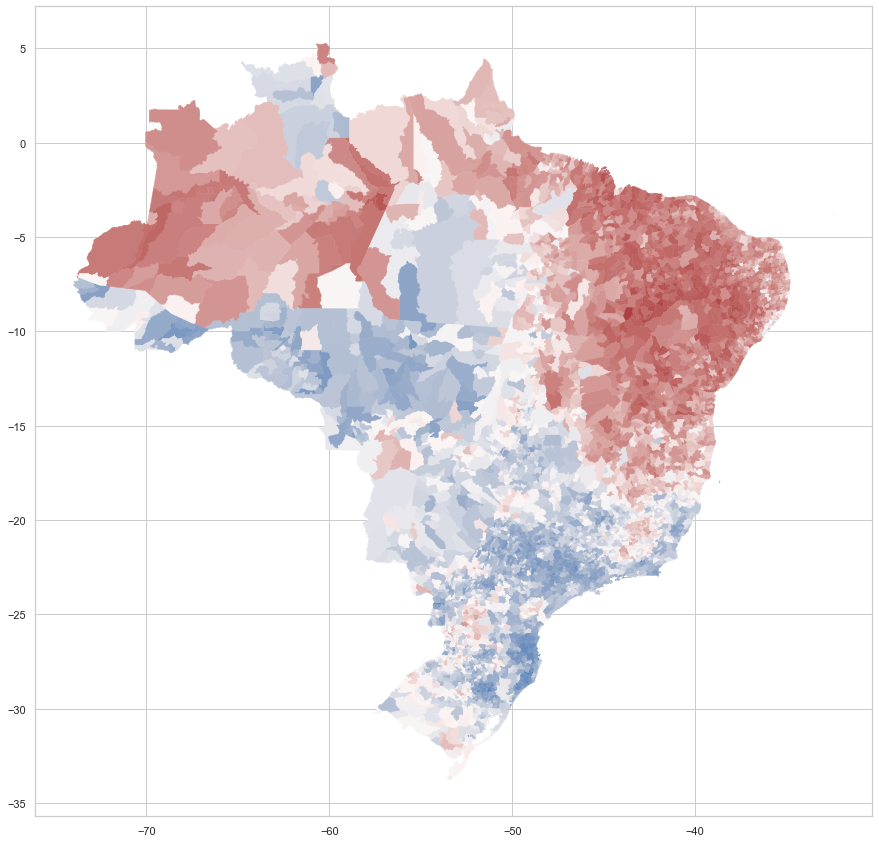

In [118]:
bozomap.plot(column='Bolsonaro_pct', cmap=blue_white_red, edgecolor="face", linewidth=0.4, figsize=(15,15),vmin=0,vmax=100)

In [ ]:
bozomap.plot(column='Bolsonaro_pct', cmap=blue_white_red, edgecolor="face", linewidth=0.4, figsize=(15,15))

<AxesSubplot:>

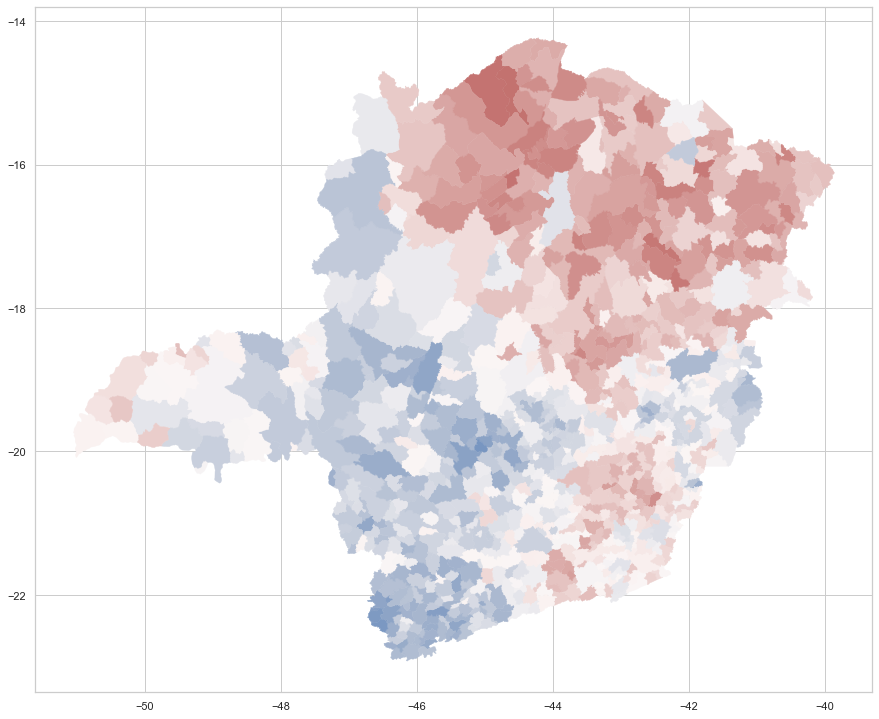

In [121]:
bozomap[bozomap.codigo_ibge.apply(lambda x: x[0:2]) == '31']\
    .plot(column='Bolsonaro_pct', 
          cmap=blue_white_red, 
          edgecolor="face", 
          linewidth=0.4, figsize=(15,15),
         vmin=0, vmax=100)

In [116]:
pivota

,codigo_tse,NM_MUNICIPIO,SG_UF,FERNANDO HADDAD,JAIR BOLSONARO,BOLSONARO_PCT,codigo_ibge
0,87220,NOVA PÁDUA,RS,134,1770,92.962,4313086
1,82937,RIO FORTUNA,SC,380,3283,89.626,4214904
2,83577,TIMBÓ,SC,2615,22582,89.622,4218202
3,80330,ASCURRA,SC,506,4257,89.376,4201703
4,83615,TREZE DE MAIO,SC,543,4503,89.239,4218400
...,...,...,...,...,...,...,...
5565,10260,FARTURA DO PIAUÍ,PI,2978,166,5.280,2203750
5566,10081,BONFIM DO PIAUÍ,PI,3241,179,5.234,2201929
5567,23167,CARNAUBEIRA DA PENHA,PE,7402,371,4.773,2603926
5568,10707,CAPITÃO GERVÁSIO OLIVEIRA,PI,2667,121,4.340,2202455


In [65]:
os.getcwd()

'C:\\Users\\rgarcia\\Documents\\data'

In [66]:
pivota.to_excel("Haddad_vs_Bolsonaro.xlsx")  

In [78]:
((pivota['Votos Bolsonaro'].sum()/(pivota['Votos Haddad'].sum()+pivota['Votos Bolsonaro'].sum()))*100).round(1)

55.1